# 02 – Supervised Regime Prediction & Markov Entropy (Advanced)

This notebook builds on the unsupervised **cosine → SSA → UMAP → HDBSCAN** pipeline and adds:

1. **Supervised regime prediction** with an SVM classifier
2. **Out‑of‑sample regime assignment** (train ≤ 2005, test & future years > 2005)
3. **Markov‑chain based entropy features** on the regime sequence
4. Integration with the **Hybrid Sniper** backtest to test robustness

The goal is to show how the unsupervised regimes can be turned into a **predictive signal** and how we can quantify **regime uncertainty** via entropy.


In [2]:
# --- Path setup so we can import the package from ../src ---
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent          # .../sp_mapping
SRC_PATH = PROJECT_ROOT / "src"           # .../sp_mapping/src

if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))
    print("Added to PYTHONPATH:", SRC_PATH)


# --- Core libraries ---
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- Project imports ---
from market_regime_sniper.pipeline import (
    load_spx_from_csv,
    build_cosine_norm_features,
    run_ssa_umap_hdbscan,
    build_clusters_df,
)

from market_regime_sniper.sniper_strategy import (
    get_regime_ids,
    run_hybrid_sniper,
)

from market_regime_sniper.my_stats import ClusterRegimeTester

# --- Notebook style ---
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 4)

Added to PYTHONPATH: /Users/stayros/Desktop/python/Μαθήματα/Data/sp_mapping/src


## 1. Load Data & Build Cosine/Norm Features

We reuse the same feature engineering pipeline as in `01_experiments`:
- Per‑year normalization of prices
- Cosine similarity between daily 2D vectors `[x_t, x_{t+1}]`
- Norm of those vectors
- Singular Spectrum Analysis (SSA) smoothing


In [3]:
# Load daily S&P 500 data from local CSV (spx.csv in the package)
spx = load_spx_from_csv()

# Build yearly cosine / norm feature matrix + annual returns
features, annual = build_cosine_norm_features(spx)
features.head(), annual.head()


(      p_cos_cos_1  p_cos_cos_2  p_cos_cos_3  p_cos_cos_4  p_cos_cos_5  \
 1950     0.999995     1.000000     0.999998     0.999994     0.999999   
 1951     0.999980     0.999991     1.000000     0.999997     1.000000   
 1952     1.000000     1.000000     0.999999     0.999999     1.000000   
 1953     0.999984     0.999999     0.999999     0.999992     1.000000   
 1954     0.999998     0.999997     0.999999     1.000000     0.999986   
 
       p_cos_cos_6  p_cos_cos_7  p_cos_cos_8  p_cos_cos_9  p_cos_cos_10  ...  \
 1950     0.999995     0.999934     0.999975     0.999998      0.999996  ...   
 1951     0.999957     0.999895     0.999950     0.999999      0.999988  ...   
 1952     0.999991     1.000000     1.000000     1.000000      0.999991  ...   
 1953     0.999973     0.999998     1.000000     0.999995      0.999998  ...   
 1954     1.000000     1.000000     0.999997     0.999989      0.999988  ...   
 
       p_norm_norm_222  p_norm_norm_223  p_norm_norm_224  p_norm_norm_22

## 2. SSA → UMAP → HDBSCAN (Unsupervised Regimes)

We first reconstruct the **unsupervised regimes** exactly as in the main pipeline.
These regimes will act as labels for the supervised model.


In [4]:
# Run SSA + UMAP + HDBSCAN
df_ssa, umap_2d, labels_hdb, years_df = run_ssa_umap_hdbscan(features)

years = years_df["year"].astype(int).values
unique_clusters = np.unique(labels_hdb)
print("Years span:", years.min(), "→", years.max())
print("Clusters found:", unique_clusters)


/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Years span: 1950 → 2025
Clusters found: [0 1 2 3 4]


/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [5]:
# Build cluster DataFrame with annual returns (for diagnostics)
df_clusters_unsup = build_clusters_df(
    years_index=years_df.index,
    labels=labels_hdb,
    annual_returns=annual,
)

print("[Unsupervised] Cluster-wise returns summary:")
print(df_clusters_unsup.groupby("cluster")["returns"].agg(["count", "mean", "median"]))

tester_unsup = ClusterRegimeTester(df_clusters_unsup, cluster_col="cluster", value_col="returns")
tester_unsup.pretty_print_bull_vs_rest()


[Unsupervised] Cluster-wise returns summary:
         count       mean     median
cluster                             
0           15 -14.333376 -11.121495
1           10  15.807318  15.277428
2           15   9.435854   9.735249
3           12   2.880995   2.897457
4           23  25.534041  26.390503
        BULL vs REST – Cluster Regime Tests       
Bull cluster      : 4
Other clusters    : [0, 1, 2, 3]
N (bull / rest)   : 23 / 52
Mean (bull / rest): 25.53% / 2.29%
Sharpe (bull/rest): 3.041 / 0.165

---- Mean & Distribution tests ----
Welch t-test      : t = 8.920,  p = 0.000
Mann–Whitney U    : U = 1141.000,  p = 0.000
Levene (variance) : stat = 8.487, p = 0.005
Cohen's d         : d = 2.022
KS test           : KS = 0.803, p = 0.000
Anderson–Darling  : AD = 27.695, p ≈ 0.001

---- Sharpe / Portfolio-level tests ----
Memmel (Sharpe Δ) : z = 3.372, p = 0.001
GRS (mean eq.)    : F = 36.231, p = 0.000


/Users/stayros/Desktop/python/Μαθήματα/Data/sp_mapping/src/market_regime_sniper/my_stats.py:139: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([a, b])


## 3. Train / Test Split on Years

We now split by **calendar year**, not by random shuffling:

- **Train years**: 1950–2005  
- **Test years**:  2006–latest available

This reflects a realistic "train on past, predict future" setting.


In [6]:
# Convert to numpy for modelling
X_all = df_ssa.values.astype(float)

train_cutoff = 2005
train_mask = years <= train_cutoff
test_mask  = years > train_cutoff

train_years = years[train_mask]
test_years  = years[test_mask]

X_train_raw = X_all[train_mask]
X_test_raw  = X_all[test_mask]
y_train_unsup = labels_hdb[train_mask]   # unsupervised labels only for the training period

print(f"Train years: {train_years.min()} → {train_years.max()} | shape={X_train_raw.shape}")
print(f"Test years : {test_years.min()} → {test_years.max()} | shape={X_test_raw.shape}")
print("Train clusters:", np.unique(y_train_unsup))


Train years: 1950 → 2005 | shape=(55, 462)
Test years : 2006 → 2025 | shape=(20, 462)
Train clusters: [0 1 2 3 4]


## 4. UMAP Embedding (Train‑Only) & HDBSCAN on Train

To avoid peeking into the future, we fit UMAP only on the **training** years and later transform the test years.

We then re‑cluster only the **train UMAP space** with HDBSCAN. These cluster labels become our **ground‑truth regimes** for supervised learning.


In [7]:
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_score

# Fit UMAP on train only
umap_model = umap.UMAP(
    n_neighbors=6,
    min_dist=0.001,
    metric="euclidean",
    random_state=42,
)

umap_train = umap_model.fit_transform(X_train_raw)
umap_test  = umap_model.transform(X_test_raw)

print("UMAP train shape:", umap_train.shape)
print("UMAP test  shape:", umap_test.shape)

# HDBSCAN on train UMAP space
hdb = hdbscan.HDBSCAN(
    min_cluster_size=6,
    min_samples=6,
    prediction_data=True,
    cluster_selection_epsilon=0.0,
)
hdb.fit(umap_train)
cluster_train = hdb.labels_

print("Unique train clusters:", np.unique(cluster_train))
print("HDBSCAN Silhouette (train):",
      silhouette_score(umap_train, cluster_train))


/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP train shape: (55, 2)
UMAP test  shape: (20, 2)
Unique train clusters: [0 1 2 3]
HDBSCAN Silhouette (train): 0.8913679122924805


/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
# Cluster-wise returns on TRAIN ONLY
annual_train = annual.loc[train_years]

df_clusters_train = pd.DataFrame(index=train_years)
df_clusters_train["cluster"] = cluster_train
df_clusters_train["returns"] = annual_train["returns"].values

print("\n[TRAIN] Cluster-wise mean annual returns:")
print(df_clusters_train.groupby("cluster")["returns"].agg(["count", "mean", "median"]))

tester_train = ClusterRegimeTester(df_clusters_train, cluster_col="cluster", value_col="returns")
tester_train.pretty_print_bull_vs_rest()



[TRAIN] Cluster-wise mean annual returns:
         count       mean     median
cluster                             
0           27  22.405336  22.319395
1           13 -12.112534 -11.076663
2            8   1.261497   2.897457
3            7   7.261602   8.026696
        BULL vs REST – Cluster Regime Tests       
Bull cluster      : 0
Other clusters    : [1, 2, 3]
N (bull / rest)   : 27 / 28
Mean (bull / rest): 22.41% / -3.45%
Sharpe (bull/rest): 2.483 / -0.309

---- Mean & Distribution tests ----
Welch t-test      : t = 9.460,  p = 0.000
Mann–Whitney U    : U = 739.000,  p = 0.000
Levene (variance) : stat = 2.478, p = 0.121
Cohen's d         : d = 2.547
KS test           : KS = 0.892, p = 0.000
Anderson–Darling  : AD = 24.884, p ≈ 0.001

---- Sharpe / Portfolio-level tests ----
Memmel (Sharpe Δ) : z = 4.443, p = 0.000
GRS (mean eq.)    : F = 80.748, p = 0.000


/Users/stayros/Desktop/python/Μαθήματα/Data/sp_mapping/src/market_regime_sniper/my_stats.py:139: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([a, b])


## 5. Supervised SVM: Learn Regime Boundaries

We now train an SVM classifier on the **train UMAP embeddings → cluster labels**.

To keep a small validation slice, we further split the training years:

- **Supervised train**: 1950–2000  
- **Validation**:       2001–2005

This lets us check whether the classifier can recover the unsupervised regimes.


In [9]:
# Supervised train / validation split inside train years
cutoff_supervised = 2000

sup_train_mask = train_years <= cutoff_supervised
sup_val_mask   = train_years > cutoff_supervised

X_sup_train = umap_train[sup_train_mask]
y_sup_train = cluster_train[sup_train_mask].astype(int)

X_sup_val   = umap_train[sup_val_mask]
y_sup_val   = cluster_train[sup_val_mask].astype(int)

print("Supervised TRAIN years:", train_years[sup_train_mask][0], "→", train_years[sup_train_mask][-1],
      "| shape:", X_sup_train.shape)
print("Supervised VAL   years:", train_years[sup_val_mask][0], "→", train_years[sup_val_mask][-1],
      "| shape:", X_sup_val.shape)
print("Classes in y_sup_train:", np.unique(y_sup_train))


Supervised TRAIN years: 1950 → 2000 | shape: (50, 2)
Supervised VAL   years: 2001 → 2005 | shape: (5, 2)
Classes in y_sup_train: [0 1 2 3]


In [10]:
# Train an SVM classifier on UMAP space
svm = SVC(
    C=100,
    kernel="rbf",
    probability=False,
    random_state=42,
)

svm.fit(X_sup_train, y_sup_train)
val_pred = svm.predict(X_sup_val)

print("\n=== Validation SVM (2001–2005) Classification Report ===")
print(classification_report(y_sup_val, val_pred, digits=3))

print("\n=== Validation Confusion Matrix (rows=true, cols=pred) ===")
print(confusion_matrix(y_sup_val, val_pred))



=== Validation SVM (2001–2005) Classification Report ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         2
           2      1.000     1.000     1.000         2

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5


=== Validation Confusion Matrix (rows=true, cols=pred) ===
[[1 0 0]
 [0 2 0]
 [0 0 2]]


## 6. Predict Regimes for Future Years (>2005)

We now use the trained SVM to assign regime labels to **test years** that were never seen by HDBSCAN.

- For years ≤ 2005: regime = unsupervised HDBSCAN cluster  
- For years > 2005: regime = SVM‑predicted cluster


In [11]:
# Predict clusters for test years
y_test_pred = svm.predict(umap_test).astype(int)

print("Test years range:", test_years[0], "→", test_years[-1])
print("Predicted clusters in test:", np.unique(y_test_pred))

# Build unified cluster DataFrame (oracle + predicted)
df_clusters_all = pd.DataFrame(index=years)
df_clusters_all.loc[train_years, "cluster"] = cluster_train          # oracle (HDBSCAN)
df_clusters_all.loc[test_years,  "cluster"] = y_test_pred            # SVM‑predicted
df_clusters_all["cluster"] = df_clusters_all["cluster"].astype(int)
df_clusters_all["returns"] = annual.loc[years, "returns"].values

print("\nUnified clusters (first & last rows):")
print(df_clusters_all.head())
print(df_clusters_all.tail())

tester_all = ClusterRegimeTester(df_clusters_all, cluster_col="cluster", value_col="returns")
tester_all.pretty_print_bull_vs_rest()


Test years range: 2006 → 2025
Predicted clusters in test: [0 1 2 3]

Unified clusters (first & last rows):
      cluster    returns
1950        0  22.509004
1951        0  14.443909
1952        3  11.638655
1953        1  -6.518463
1954        0  44.208417
      cluster    returns
2021        0  28.793050
2022        1 -19.953050
2023        0  24.729482
2024        0  24.010981
2025        0  16.664423
        BULL vs REST – Cluster Regime Tests       
Bull cluster      : 0
Other clusters    : [1, 2, 3]
N (bull / rest)   : 36 / 39
Mean (bull / rest): 22.13% / -2.31%
Sharpe (bull/rest): 2.627 / -0.179

---- Mean & Distribution tests ----
Welch t-test      : t = 9.762,  p = 0.000
Mann–Whitney U    : U = 1356.000,  p = 0.000
Levene (variance) : stat = 6.005, p = 0.017
Cohen's d         : d = 2.238
KS test           : KS = 0.844, p = 0.000
Anderson–Darling  : AD = 32.165, p ≈ 0.001

---- Sharpe / Portfolio-level tests ----
Memmel (Sharpe Δ) : z = 3.084, p = 0.002
GRS (mean eq.)    : F = 8

/Users/stayros/Desktop/python/Μαθήματα/Data/sp_mapping/src/market_regime_sniper/my_stats.py:139: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([a, b])


## 7. Markov Chain on Regimes & Entropy Features

We now treat the annual regime sequence as a **Markov chain**:

- Each cluster is a state
- We estimate the transition matrix \(P_{ij} = P(S_{t+1}=j \mid S_t=i)\)
- From \(P\) and the empirical stationary distribution \(\pi\) we compute:
  - **Per‑state entropy** \(H_i\) (how unpredictable is the next state given state i)
  - **Entropy rate** of the chain
- Finally, we build **entropy features over time** using expanding / rolling windows.


In [12]:
def build_markov_chain(cluster_series: pd.Series):
    s = cluster_series.sort_index().astype(int)
    states = np.sort(s.unique())
    state_to_idx = {st: i for i, st in enumerate(states)}
    K = len(states)

    counts = np.zeros((K, K), dtype=float)
    vals = s.values

    for i in range(len(vals) - 1):
        i_state = state_to_idx[vals[i]]
        j_state = state_to_idx[vals[i + 1]]
        counts[i_state, j_state] += 1

    P = counts.copy()
    row_sums = P.sum(axis=1, keepdims=True)
    with np.errstate(divide="ignore", invalid="ignore"):
        P = np.where(row_sums > 0, P / row_sums, 0.0)

    pi_emp = np.array([(s == st).mean() for st in states])
    return P, states, counts, pi_emp


def entropy_per_state(P: np.ndarray, base: int = 2) -> np.ndarray:
    eps = 1e-12
    P_safe = np.clip(P, eps, 1.0)
    logP = np.log(P_safe) / np.log(base)
    H = -np.sum(P_safe * logP, axis=1)
    H[np.isnan(H)] = 0.0
    return H


def entropy_rate(P: np.ndarray, pi: np.ndarray | None = None, base: int = 2) -> tuple[float, np.ndarray]:
    H_state = entropy_per_state(P, base=base)
    if pi is None:
        K = P.shape[0]
        pi = np.ones(K) / K
    else:
        pi = np.asarray(pi, dtype=float)
        pi = pi / (pi.sum() + 1e-12)
    return float(np.dot(pi, H_state)), H_state


In [13]:
def markov_entropy_feature(cluster_series: pd.Series, window: int | None = None,
                            base: int = 2, min_history: int = 5) -> pd.Series:
    s = cluster_series.sort_index().astype(int)
    years = s.index.values
    vals = s.values
    entropy_values: list[float] = []

    for i in range(len(years)):
        if window is None:
            start_idx = 0
        else:
            start_idx = max(0, i - window)

        if i - start_idx < min_history:
            entropy_values.append(np.nan)
            continue

        sub_vals = vals[start_idx : i + 1]
        tmp_series = pd.Series(sub_vals, index=years[start_idx : i + 1])

        P_loc, states_loc, counts_loc, pi_loc = build_markov_chain(tmp_series)

        if (counts_loc.sum() < min_history) or (np.count_nonzero(counts_loc.sum(axis=1)) < 1):
            entropy_values.append(np.nan)
            continue

        H_loc, _ = entropy_rate(P_loc, pi=pi_loc, base=base)
        entropy_values.append(H_loc)

    return pd.Series(entropy_values, index=years, name="markov_entropy")


In [14]:
# Global Markov chain on full regime history
P, states, counts, pi_emp = build_markov_chain(df_clusters_all["cluster"])
H_rate, H_state = entropy_rate(P, pi=pi_emp, base=2)

print("States (clusters):", states)
print("Transition matrix P:\n", P)
print("Empirical π:", pi_emp)
print("Entropy per state H_i:", H_state)
print("Entropy rate H:", H_rate)


States (clusters): [0 1 2 3]
Transition matrix P:
 [[0.45714286 0.2        0.17142857 0.17142857]
 [0.6        0.2        0.06666667 0.13333333]
 [0.5        0.08333333 0.16666667 0.25      ]
 [0.33333333 0.33333333 0.25       0.08333333]]
Empirical π: [0.48 0.2  0.16 0.16]
Entropy per state H_i: [1.85296775 1.55460976 1.72957396 1.85538854]
Entropy rate H: 1.7739404707212394


In [15]:
# Expanding & rolling 10-year entropy features
entropy_exp = markov_entropy_feature(df_clusters_all["cluster"], window=None, base=2, min_history=5)
entropy_win10 = markov_entropy_feature(df_clusters_all["cluster"], window=10, base=2, min_history=5)

df_clusters_all["markov_entropy_exp"] = entropy_exp
df_clusters_all["markov_entropy_win10"] = entropy_win10

df_clusters_all.head(15)


,cluster,returns,markov_entropy_exp,markov_entropy_win10
1950,0,22.509004,NaN,NaN
1951,0,14.443909,NaN,NaN
1952,3,11.638655,NaN,NaN
1953,1,-6.518463,NaN,NaN
1954,0,44.208417,NaN,NaN
1955,0,23.755102,0.612197,0.612197
1956,3,3.343667,0.571429,0.571429
1957,2,-13.441558,0.750000,0.750000
1958,0,36.895611,0.777778,0.777778
1959,3,8.026696,0.785475,0.785475


## 8. Hybrid Sniper Backtest with Oracle + Predicted Regimes

Finally, we plug the unified regime labels (oracle + SVM‑predicted) into the **Hybrid Sniper** strategy to test whether:

- Out‑of‑sample regime prediction still produces a **strong DCA overlay**, and  
- The Markov entropy features can later be used as **extra state variables** (e.g. low‑entropy = stable regime, high‑entropy = uncertain / transition phase).


=== Hybrid Sniper Backtest on Oracle + SVM-Predicted Regimes ===


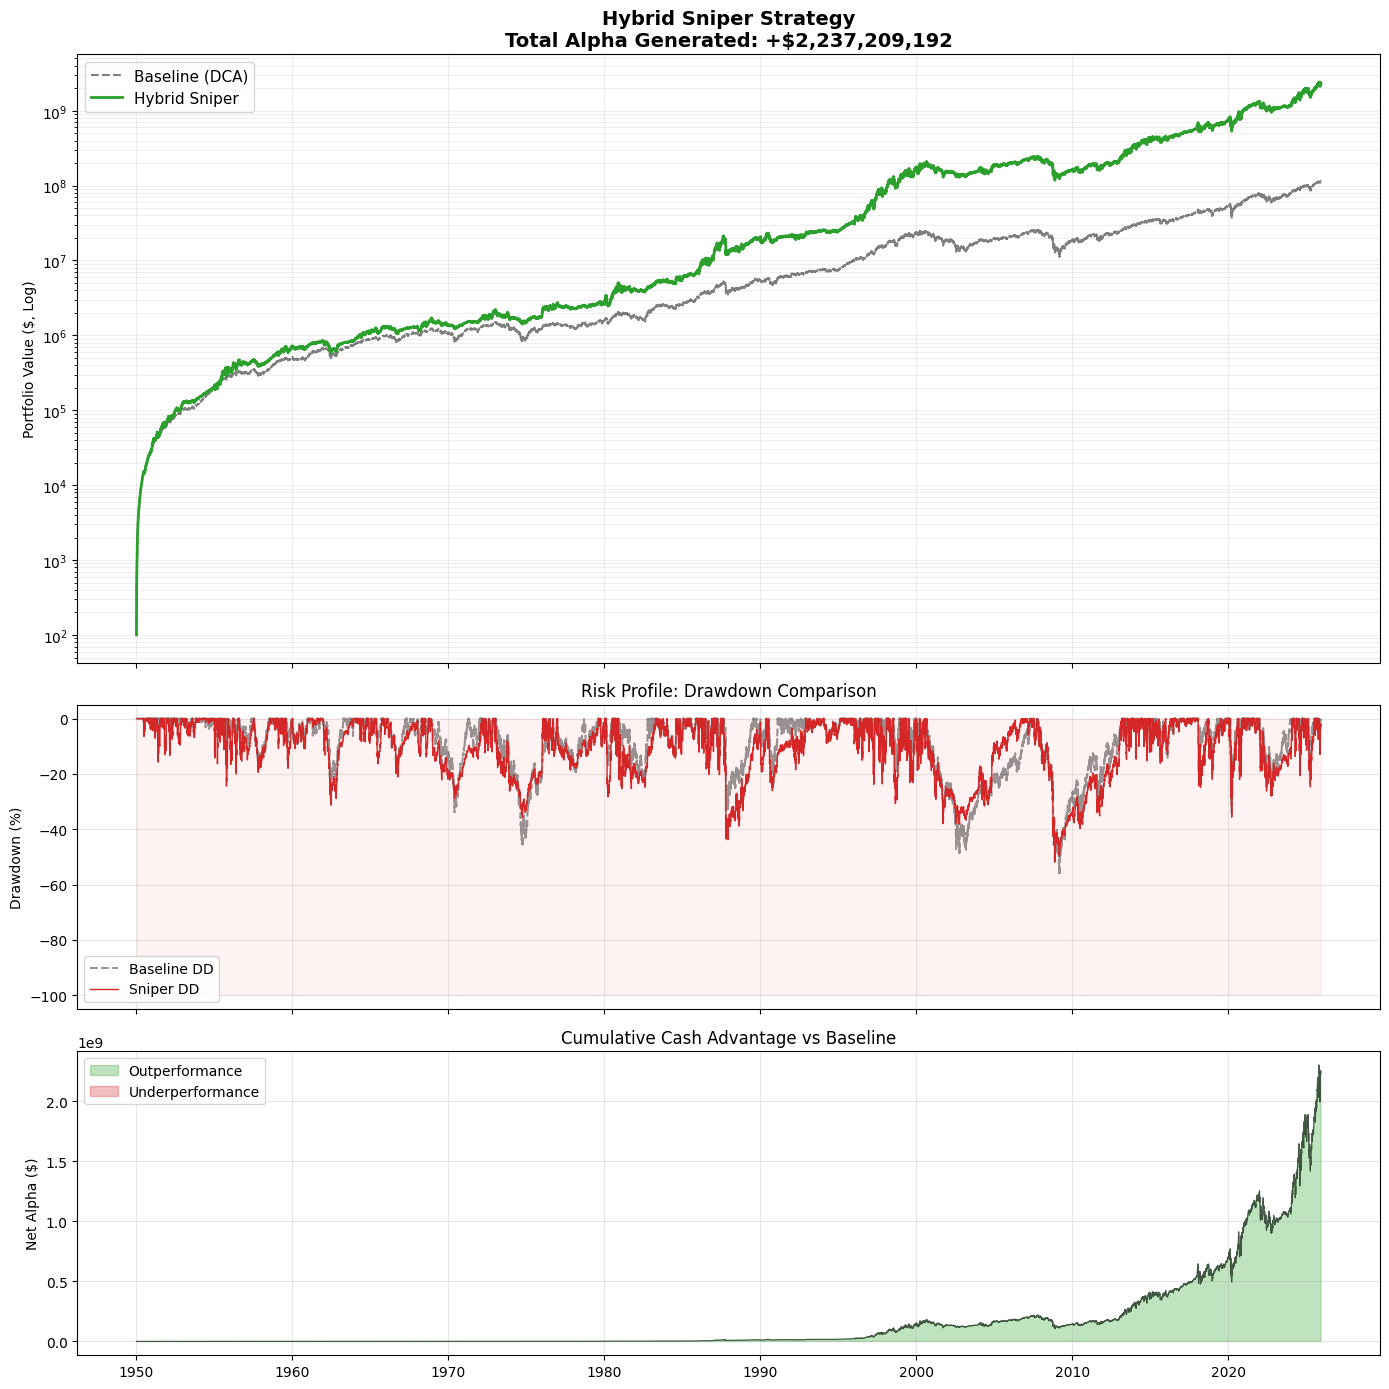

,Final Equity ($),CAGR (%),Max DD (%),Sharpe,Calmar
Strategy,,,,,
Baseline (DCA),1.145122e+08,5.53,-56.69,0.803,0.098
Hybrid Sniper (Vol Scaled),2.351721e+09,9.82,-51.92,0.848,0.189


In [16]:
print("=== Hybrid Sniper Backtest on Oracle + SVM-Predicted Regimes ===")
results_all = run_hybrid_sniper(price_df=spx, clusters_df=df_clusters_all)
results_all


## 9. Takeaways

- The SVM can **learn the regime structure** discovered by HDBSCAN in UMAP space and extend it to unseen years.  
- The unified regime sequence exhibits **non‑random transition structure**, which can be summarised via Markov entropy.  
- These entropy features act as a compact measure of **regime uncertainty / stability**, and can be plugged into:
  - more advanced dynamic strategies,
  - regime‑switching models,
  - or as extra covariates in supervised models.

This notebook is intentionally self‑contained and designed as an **advanced, but readable, complement** to `01_experiments.ipynb`.
